In [2]:
import geopandas as gpd


Here, we are defining the dominance area for each of those shopping centers( Jumbo, Dixi, Myyrmanni, Itis, Forum, IsoOmena, Ruoholahti) based on public transport travel time.

In [4]:
from pyproj import CRS
import matplotlib.pyplot as plt

# Reading TravelTimes_to_5975375_RailwayStation.shp shapefile into a variable called grid
# reading roads, metro shape file
grid_fp = "data/dataE5/TravelTimes_to_5975375_RailwayStation.shp"
roads_fp = "data/dataE5/roads.shp"
metro_fp = "data/dataE5/metro.shp"

# Read files
grid = gpd.read_file(grid_fp)
roads = gpd.read_file(roads_fp)
metro = gpd.read_file(metro_fp)

Fetching the filepaths to all textfiles found in data/ directory that contain information about the travel times to different shopping centers

In [5]:
# glob.glob() -function to list the filenames into a list called filepaths
import glob
filepaths = glob.glob(r'data_travel_time//TravelTimes_to*')

Joining information from all the input layers into the grid.

In [10]:
import pandas as pd
# reading filepaths
# Selecting columns from_id and pt_r_t
# Renaming the column pt_r_t in a way that it has contains the shopping center name.
# On first iteration the column name should be pt_r_t_Jumbo
# Making a table join between the grid GeoDataFrame and the travel times 
# (with updated column name) using the merge() function
for each_filepath in filepaths:
    content = pd.read_csv(each_filepath,usecols=["from_id","pt_r_t"],sep = ';')
    mall_name = each_filepath.split("_")[-1].split(".")[0]
    content.columns = ["from_id","pt_r_t_"+mall_name]
    grid = grid.merge(content,on="from_id",how="inner")

Removing rows containing -1 (no data values) from the dataframe using np.nan

In [11]:
import numpy as np
grid = grid.replace(-1, np.nan)
grid = grid.dropna()

reprojecting coordinate reference sytem to grid's crs for rest of the shape files

In [12]:
roads = roads.to_crs(crs=grid.crs)
metro = metro.to_crs(crs=grid.crs)

For each grid cell (each row), finding out the shortest travel time to any shopping center. Storing the result in a new column 'min_t'

In [13]:
# Creating a new column for minimum travel time values 
malls = ["pt_r_t_Jumbo","pt_r_t_Dixi", "pt_r_t_Myyrmanni",  "pt_r_t_Itis",  "pt_r_t_Forum" , "pt_r_t_IsoOmena", "pt_r_t_Ruoholahti"]
grid['min_t'] = grid[malls].min(axis=1)

# Create a new column for the closest shopping center id values
grid['dominant_service'] = grid[malls].idxmin(axis=1)

Visualizing travel times to shopping centers from the min_t column

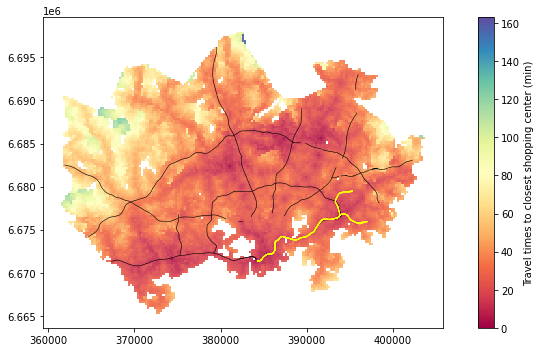

In [14]:
# Create one subplot. Control figure size in here.
fig, ax = plt.subplots(figsize=(10,5))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(ax=ax, column="min_t", linewidth=0.03, cmap= "Spectral", k=10, alpha=.9,legend=True, legend_kwds={'label': "Travel times to closest shopping center (min)"})

                       
# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=ax, color="black", linewidth=.6)

# Add metro on top of the previous map
metro.plot(ax=ax, color="yellow", linewidth= .9)

# Remove the empty white-space around the axes
plt.tight_layout()



Reprojecting the layer to ESPG 3857 projection (Web Mercator):
    - since map tiles are typically distributed in Web Mercator projection (EPSG:3857)

In [9]:
import contextily as ctx
%matplotlib inline

data = grid.to_crs(epsg=3857)
roads = roads.to_crs(epsg=3857)
metro = metro.to_crs(epsg=3857)
print(data.crs)

epsg:3857


credits stored in a variable 

In [10]:
credits = "Travel time data by Digital Geography Lab, Map Data © OpenStreetMap contributors"

publishing as a static map

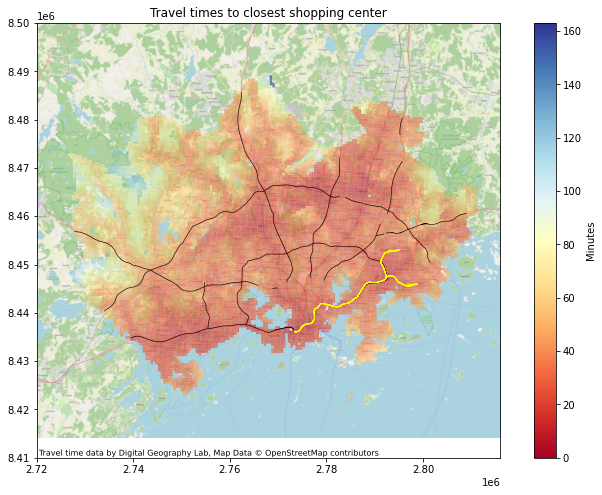

In [13]:

fig, ax = plt.subplots(figsize=(12,8))

# Plot the data
data.plot(ax=ax, column='min_t', cmap='RdYlBu', linewidth=0, k=9, alpha=0.6,legend=True, legend_kwds={'label': "Minutes"})
roads.plot(ax=ax, color="black", linewidth=.6 )
metro.plot(ax=ax, color="yellow", linewidth= .9)



# Add basemap with `OSM_A` style using zoom level of 11 
# Modify the attribution 
# ctx.add_basemap(ax, zoom=15, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik)

ctx.add_basemap(ax, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik)

# Crop the figure
ax.set_xlim(2720000, 2816000)
ax.set_ylim(8410000, 8500000)
ax.set_title("Travel times to closest shopping center")
# Save the figure as png file with resolution of 300 dpi
outfp = "docs/static_map.png"
plt.savefig(outfp, dpi=300)